In [165]:
import pandas as pd
import catboost 
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense
from keras import backend as K
from keras import models
from keras import layers
from keras import regularizers
from keras import models
from keras import layers
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.ensemble import StackingClassifier
from sklearn.preprocessing import QuantileTransformer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import power_transform
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import shap
from sklearn.model_selection import cross_val_score

# opcje:
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 60)
pd.set_option('display.max_columns', None)

### Basics

In [72]:
df = pd.read_csv('../../data/final_train.csv', index_col=0)

In [73]:
df

,Activity,"angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyAccMean,gravity)","angle(tBodyGyroJerkMean,gravityMean)","angle(tBodyGyroMean,gravityMean)",energy-mean(),"fBodyAcc-bandsEnergy()-1,16","fBodyAcc-bandsEnergy()-1,16.1","fBodyAcc-bandsEnergy()-1,16.2","fBodyAcc-bandsEnergy()-1,24","fBodyAcc-bandsEnergy()-1,24.1","fBodyAcc-bandsEnergy()-1,24.2","fBodyAcc-bandsEnergy()-1,8","fBodyAcc-bandsEnergy()-1,8.1","fBodyAcc-bandsEnergy()-1,8.2","fBodyAcc-bandsEnergy()-17,24","fBodyAcc-bandsEnergy()-17,24.1","fBodyAcc-bandsEnergy()-17,24.2","fBodyAcc-bandsEnergy()-17,32","fBodyAcc-bandsEnergy()-17,32.1","fBodyAcc-bandsEnergy()-17,32.2","fBodyAcc-bandsEnergy()-25,32","fBodyAcc-bandsEnergy()-25,32.1","fBodyAcc-bandsEnergy()-25,32.2","fBodyAcc-bandsEnergy()-25,48","fBodyAcc-bandsEnergy()-25,48.1","fBodyAcc-bandsEnergy()-25,48.2","fBodyAcc-bandsEnergy()-33,40","fBodyAcc-bandsEnergy()-33,40.1","fBodyAcc-bandsEnergy()-33,40.2","fBodyAcc-bandsEnergy()-33,48","fBodyAcc-bandsEnergy()-33,48.1","fBodyAcc-bandsEnergy()-33,48.2","fBodyAcc-bandsEnergy()-41,48","fBodyAcc-bandsEnergy()-41,48.1","fBodyAcc-bandsEnergy()-41,48.2","fBodyAcc-bandsEnergy()-49,56","fBodyAcc-bandsEnergy()-49,56.1","fBodyAcc-bandsEnergy()-49,56.2","fBodyAcc-bandsEnergy()-49,64","fBodyAcc-bandsEnergy()-49,64.1","fBodyAcc-bandsEnergy()-49,64.2","fBodyAcc-bandsEnergy()-57,64","fBodyAcc-bandsEnergy()-57,64.1","fBodyAcc-bandsEnergy()-57,64.2","fBodyAcc-bandsEnergy()-9,16","fBodyAcc-bandsEnergy()-9,16.1","fBodyAcc-bandsEnergy()-9,16.2",fBodyAcc-energy()-X,fBodyAcc-energy()-Y,fBodyAcc-energy()-Z,fBodyAcc-entropy()-X,fBodyAcc-entropy()-Y,fBodyAcc-entropy()-Z,fBodyAcc-iqr()-X,fBodyAcc-iqr()-Y,fBodyAcc-iqr()-Z,fBodyAcc-kurtosis()-X,fBodyAcc-kurtosis()-Y,fBodyAcc-kurtosis()-Z,fBodyAcc-mad()-X,fBodyAcc-mad()-Y,fBodyAcc-mad()-Z,fBodyAcc-main()-X,fBodyAcc-main()-Y,fBodyAcc-main()-Z,fBodyAcc-max()-X,fBodyAcc-max()-Y,fBodyAcc-max()-Z,fBodyAcc-maxInds-X,fBodyAcc-maxInds-Y,fBodyAcc-maxInds-Z,fBodyAcc-mean()-X,fBodyAcc-mean()-Y,fBodyAcc-mean()-Z,fBodyAcc-meanFreq()-X,fBodyAcc-meanFreq()-Y,fBodyAcc-meanFreq()-Z,fBodyAcc-min()-X,fBodyAcc-min()-Y,fBodyAcc-min()-Z,fBodyAcc-skewness()-X,fBodyAcc-skewness()-Y,fBodyAcc-skewness()-Z,fBodyAcc-sma(),fBodyAcc-std()-X,fBodyAcc-std()-Y,fBodyAcc-std()-Z,"fBodyAccJerk-bandsEnergy()-1,16","fBodyAccJerk-bandsEnergy()-1,16.1","fBodyAccJerk-bandsEnergy()-1,16.2","fBodyAccJerk-bandsEnergy()-1,24","fBodyAccJerk-bandsEnergy()-1,24.1","fBodyAccJerk-bandsEnergy()-1,24.2","fBodyAccJerk-bandsEnergy()-1,8","fBodyAccJerk-bandsEnergy()-1,8.1","fBodyAccJerk-bandsEnergy()-1,8.2","fBodyAccJerk-bandsEnergy()-17,24","fBodyAccJerk-bandsEnergy()-17,24.1","fBodyAccJerk-bandsEnergy()-17,24.2","fBodyAccJerk-bandsEnergy()-17,32","fBodyAccJerk-bandsEnergy()-17,32.1","fBodyAccJerk-bandsEnergy()-17,32.2","fBodyAccJerk-bandsEnergy()-25,32","fBodyAccJerk-bandsEnergy()-25,32.1","fBodyAccJerk-bandsEnergy()-25,32.2","fBodyAccJerk-bandsEnergy()-25,48","fBodyAccJerk-bandsEnergy()-25,48.1","fBodyAccJerk-bandsEnergy()-25,48.2","fBodyAccJerk-bandsEnergy()-33,40","fBodyAccJerk-bandsEnergy()-33,40.1","fBodyAccJerk-bandsEnergy()-33,40.2","fBodyAccJerk-bandsEnergy()-33,48","fBodyAccJerk-bandsEnergy()-33,48.1","fBodyAccJerk-bandsEnergy()-33,48.2","fBodyAccJerk-bandsEnergy()-41,48","fBodyAccJerk-bandsEnergy()-41,48.1","fBodyAccJerk-bandsEnergy()-41,48.2","fBodyAccJerk-bandsEnergy()-49,56","fBodyAccJerk-bandsEnergy()-49,56.1","fBodyAccJerk-bandsEnergy()-49,56.2","fBodyAccJerk-bandsEnergy()-49,64","fBodyAccJerk-bandsEnergy()-49,64.1","fBodyAccJerk-bandsEnergy()-49,64.2","fBodyAccJerk-bandsEnergy()-57,64","fBodyAccJerk-bandsEnergy()-57,64.1","fBodyAccJerk-bandsEnergy()-57,64.2","fBodyAccJerk-bandsEnergy()-9,16","fBodyAccJerk-bandsEnergy()-9,16.1","fBodyAccJerk-bandsEnergy()-9,16.2",fBodyAccJerk-energy()-X,fBodyAccJerk-energy()-Y,fBodyAccJerk-energy()-Z,fBodyAccJerk-entropy()-X,fBodyAccJerk-entropy()-Y,fBodyAccJerk-entropy()-Z,fBodyAc

In [74]:
df = df.drop_duplicates()

In [75]:
df.shape

(10975, 572)

In [76]:
df['Activity'].value_counts()

LAYING                2117
SITTING               2006
STANDING              1977
WALKING               1897
WALKING_UPSTAIRS      1592
WALKING_DOWNSTAIRS    1386
Name: Activity, dtype: int64

In [77]:
def count_null_rows(data_frame):
    """
    Counting percentage of missing data by columns.
    """
    counter = (len(data_frame) - data_frame.count())
    percent = counter/len(data_frame) 
    frame = pd.concat([counter, percent], axis=1)
    frame = frame.rename(columns={0: 'r', 1: '%'})
    frame['%'] = round(frame['%']*100, 2)
    return frame.sort_values(by=frame.columns[0], ascending=True)

In [78]:
count_null_rows(df)

,r,%
Activity,0,0.00
subject,0,0.00
fBodyAcc-entropy()-Y,38,0.35
fBodyAcc-main()-Z,39,0.36
tGravityAcc-std()-X,40,0.36
...,...,...
fBodyAccMag-iqr(),76,0.69
fBodyAccJerk-std()-Y,77,0.70
tBodyAccMag-sma(),77,0.70
"fBodyAcc-bandsEnergy()-49,56",79,0.72


### Data preprocessing

In [79]:
# def get_boolean_from_categorical(data_frame, col_name, leave_nans=True):
#     """
#     Creating as much new columns as unique values are in original column.
#     New columns are in a style is_value_name_(original_column_name) and 
#     are fulfilled with binary values, if specific observation have particular 
#     value in original column, new value will be 1, in other cases 0. Parameter 
#     leave_nans, by default set as True, specify if missing values will be 0 or 
#     original. This function in fact is something like 'scikit learn's one-hot 
#     encoding' functions.
#     """
#     list_of_items = data_frame[col_name].unique().tolist()
#     if np.nan in list_of_items: 
#         list_of_items.remove(np.nan)
#     for elem in range(len(list_of_items)):
#         x = list_of_items[elem]
#         name = 'is_' + str(list_of_items[elem]) + '_(' + col_name + ')'
#         bool_list = []
#         for i in data_frame[col_name]:
#             if  leave_nans is True:
#                 if x == i:
#                     bool_list.append(1)
#                 elif isinstance(i, float) == True:                                                                            
#                     bool_list.append(np.nan)
#                 else:
#                     bool_list.append(0)
#             else:
#                 if x == i:
#                     bool_list.append(1)
#                 else:
#                     bool_list.append(0)
#         data_frame[name] = bool_list
#         if  leave_nans is True: 
#             data_frame[name] = data_frame[name].astype("Int64") 
#         else:
#             data_frame[name] = data_frame[name].astype("int64") 
            
#     data_frame = data_frame.drop(col_name, axis = 1)
            
#     return data_frame

In [80]:
persons = df['subject'].unique().tolist()

In [81]:
subject = df['subject']
target = df['Activity']
df = df.drop('Activity', axis = 1)

In [82]:
for person in persons:       
    imputer = KNNImputer(n_neighbors=5) 
    df[df['subject']==person] = imputer.fit_transform(df[df['subject']==person])
#     imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
#     imp_mean.fit(df[df['subject']==person])
#     df[df['subject']==person] = imp_mean.transform(df[df['subject']==person])

xyz_bands_energy = np.array(sorted([column for column in df.columns if "bandsEnergy" in column])).reshape(-1, 3)
for xyz in xyz_bands_energy:
    df[f"{xyz[0]}_euclid"] = (df[xyz] ** 2).sum(axis=1)
    df.drop(columns=xyz, inplace=True)

for person in persons:   
    scaler = StandardScaler()
    df[df['subject']==person] = scaler.fit_transform(df[df['subject']==person])

In [83]:
# df = get_boolean_from_categorical(df, 'subject')

In [84]:
df['subject'] = subject

In [85]:
y = target
X = df.drop(['void()'], axis=1)

In [86]:
# imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

In [87]:
# imp_mean.fit(X)

In [88]:
# X = imp_mean.transform(X)

In [89]:
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

In [90]:
# print('Mean:', round(X[:,0].mean()))
# print('Standard deviation:', round(X[:,0].std()))

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 444)

### Logistic Regression

In [92]:
# model = LogisticRegression()

# model.fit(X_train, y_train)

In [93]:
# predicted = model.predict(X_test)

In [94]:
# np.mean(predicted == y_test)

In [95]:
# BEST = 0.9870715574263379

### Catboost

In [96]:
cat_features = ["subject"]

In [97]:
X_train["subject"], X_test["subject"] = X_train["subject"].astype("int8"), X_test["subject"].astype("int8")

In [98]:
classifier = catboost.CatBoostClassifier(
    task_type="GPU", 
    devices="0",
    iterations=7000,
    metric_period=500,
)

In [99]:
classifier.fit(X_train, y_train, cat_features=cat_features, verbose=1)

Learning rate set to 0.019452
0:	learn: 1.7435574	total: 17.2ms	remaining: 2m
500:	learn: 0.0573158	total: 6.66s	remaining: 1m 26s
1000:	learn: 0.0262181	total: 13.1s	remaining: 1m 18s
1500:	learn: 0.0160638	total: 19.5s	remaining: 1m 11s
2000:	learn: 0.0109236	total: 26s	remaining: 1m 4s
2500:	learn: 0.0079758	total: 32.8s	remaining: 59.1s
3000:	learn: 0.0062434	total: 42s	remaining: 56s
3500:	learn: 0.0050153	total: 51s	remaining: 51s
4000:	learn: 0.0041628	total: 1m	remaining: 45.1s
4500:	learn: 0.0035329	total: 1m 9s	remaining: 38.3s
5000:	learn: 0.0030584	total: 1m 17s	remaining: 31s
5500:	learn: 0.0026716	total: 1m 26s	remaining: 23.5s
6000:	learn: 0.0023653	total: 1m 34s	remaining: 15.8s
6500:	learn: 0.0021088	total: 1m 43s	remaining: 7.92s
6999:	learn: 0.0018958	total: 1m 52s	remaining: 0us


In [100]:
y_hat = classifier.predict(X_test)

In [101]:
accuracy_score(y_test, y_hat)

0.9978742787731552

In [102]:
# BEST = 0.99789536981359

### Stacking 

In [103]:
# models = [
#     ('lr', LogisticRegression()),
#     ('cat', catboost.CatBoostClassifier(
#         task_type="GPU", 
#         devices="0",
#         iterations=7000,
#         metric_period=500,
#         verbose=True,
#         cat_features = cat_features,
#         )
#     )
# ]
    
# stacking = StackingClassifier(estimators=models)

In [104]:
# stacking.fit(X_train, y_train)

In [105]:
# y_hat = stacking.predict(X_test)

In [106]:
accuracy_score(y_test, y_hat)

0.9978742787731552

In [107]:
# BEST = 0.9981960312687913

### Neural Networks

In [108]:
# y = np.array(df.Activity)
# le = LabelEncoder().fit(y)
# y = le.transform(y)
# # past_prediction = le.transform(train_pred)
# # test_prediction = le.transform(predicted)
# X = np.array(df.drop(['Activity','subject'], axis=1))

In [109]:
# imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

In [110]:
# imp_mean.fit(X)

In [111]:
# X = imp_mean.transform(X)

In [112]:
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

In [113]:
# print('Mean:', round(X[:,0].mean()))
# print('Standard deviation:', round(X[:,0].std()))

In [114]:
# X_train, X_test, Y_train, Y_test = train_test_split(
#     X, y, train_size=0.7, random_state=444, shuffle=True
# )

In [115]:
# # X_train = np.c_[X_train, past_prediction]
# # X_test = np.c_[X_test, test_prediction]

In [116]:
# X_val, X_val2, Y_val, Y_val2 = train_test_split(
#     X_test, Y_test, train_size=0.5, random_state=444, shuffle=True)

In [117]:
# X_train.shape

In [118]:
# def create_network(): 
    
#     network = keras.Sequential([
#     tf.keras.layers.Dense(571, activation=tf.nn.sigmoid, 
#                        input_shape=[571]),
#     tf.keras.layers.Dense(571, activation=tf.nn.sigmoid),
#     tf.keras.layers.Dense(6, activation=tf.nn.sigmoid),
#     tf.keras.layers.Softmax(axis=-1)
#     ])

#     optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    
#     network.compile(
#         loss='sparse_categorical_crossentropy', 
#         optimizer=optimizer, 
#         metrics =['accuracy']
#     )

#     return network

In [119]:
# net = create_network()

In [120]:
# net.summary()

In [121]:
# early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4)

In [122]:
# # Train neural network
# history = net.fit(
#     X_train, # Features
#     Y_train, # Target vector
#     epochs=200, # Number of epochs
#     verbose=1, # with output
#     batch_size=128, # Number of observations per batch
# #     validation_data=(
# #         X_val, 
# #         Y_val
# #     ), # Data for evaluation
# #     callbacks=[early_stop]
# ) 

In [123]:
# predicted = net.predict(X_test)

In [124]:
# prediction_list = []
# for prediction in range(len(predicted)):
#     prediction_list.append(predicted[prediction].tolist().index(max(predicted[prediction].tolist())))

In [125]:
# np.mean(np.array(prediction_list) == Y_test)

In [126]:
# BEST = ~0.979

### Final explaination

In [ ]:
X_train.shape

In [167]:
def perform_cross_validation(classifier, X_train, y_train, cv=5):
    scores = cross_val_score(classifier, X_train, y_train, cv=cv)
    return scores

In [169]:
cv_scores = perform_cross_validation(classifier=classifier, X_train=X_train, y_train=y_train, cv=5)

Learning rate set to 0.018586
0:	learn: 1.7296316	total: 14.1ms	remaining: 1m 38s
500:	learn: 0.0627670	total: 4.55s	remaining: 59s
1000:	learn: 0.0303757	total: 8.95s	remaining: 53.6s
1500:	learn: 0.0184807	total: 13.4s	remaining: 48.9s
2000:	learn: 0.0125394	total: 17.8s	remaining: 44.3s
2500:	learn: 0.0091283	total: 22.1s	remaining: 39.8s
3000:	learn: 0.0070787	total: 26.5s	remaining: 35.3s
3500:	learn: 0.0057024	total: 30.9s	remaining: 30.9s
4000:	learn: 0.0047458	total: 35.3s	remaining: 26.4s
4500:	learn: 0.0040000	total: 39.7s	remaining: 22s
5000:	learn: 0.0034603	total: 44s	remaining: 17.6s
5500:	learn: 0.0030303	total: 48.4s	remaining: 13.2s
6000:	learn: 0.0026779	total: 52.8s	remaining: 8.79s
6500:	learn: 0.0024021	total: 57.2s	remaining: 4.39s
6999:	learn: 0.0021683	total: 1m 1s	remaining: 0us
Learning rate set to 0.018586
0:	learn: 1.7272972	total: 11.6ms	remaining: 1m 21s
500:	learn: 0.0653942	total: 4.72s	remaining: 1m 1s
1000:	learn: 0.0312844	total: 9.4s	remaining: 56.4s

In [170]:
np.mean(cv_scores)

0.9947929374051181

In [127]:
def plot_importance(catboost_model, column_names, cols_num=20):
    """
    Function created for cotboost models to visualize feature importance. 
    It shows X most important features.
    """
    important_df = pd.DataFrame()
    important_df['feature'] = column_names
    important_df['importance'] = catboost_model.get_feature_importance()
    df_to_plot = important_df.sort_values(
        by='importance', 
        ascending=False).reset_index(drop=True).head(cols_num)
    fig = plt.figure(figsize=(17,cols_num))
    axes = fig.subplots(ncols=1, nrows=int(cols_num/5), sharey=True)
    ax_counter = 0
    for i in range(0, cols_num, 5):
        sns.barplot(df_to_plot['feature'][i:i+5],
                    df_to_plot['importance'][i:i+5], ax=axes[ax_counter])  
        ax_counter += 1
    
    for ax in axes:
        for p in ax.patches:
            ax.annotate(str(round(p.get_height(),2)), 
                        (p.get_x() * 1.005, p.get_height() * 1.01))

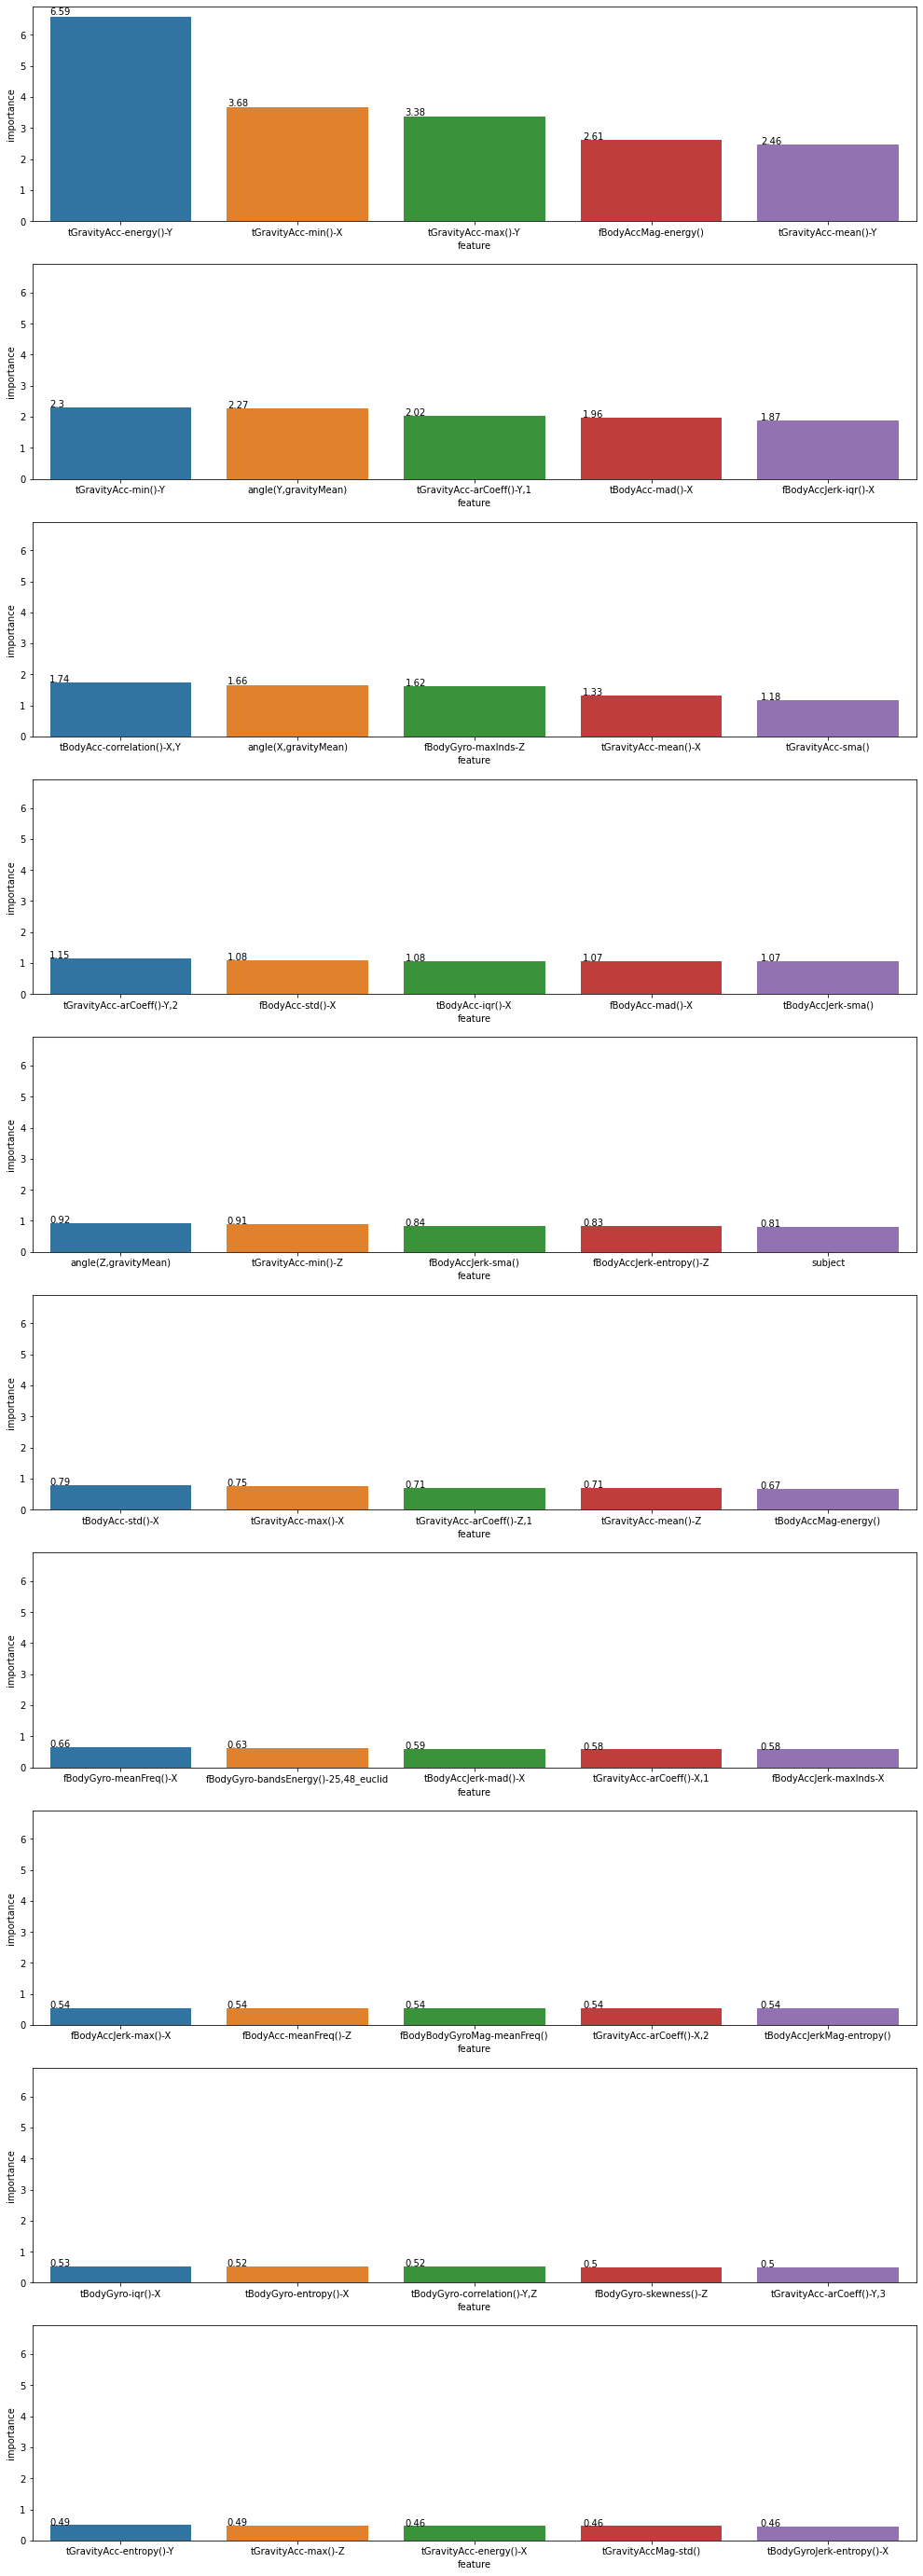

In [128]:
plot_importance(classifier, X.columns.tolist(), cols_num=50)

In [129]:
labels = list(target.unique())

In [130]:
def get_model_score_metrics(labels, y_test, y_pred):
    # accuracy for whole validation set 
    model_accuracy = accuracy_score(y_test, y_pred)
    # metrics indicating model performance for particural classes
    pr_rec_f_supp = precision_recall_fscore_support(y_test, y_pred)
    df_report = pd.DataFrame({'Precision':list(pr_rec_f_supp[0]),
                              'Recall':list(pr_rec_f_supp[1]),
                              'F-Score':list(pr_rec_f_supp[2]),
                              'Support':list(pr_rec_f_supp[3])}, index=labels)
    return model_accuracy, df_report

In [131]:
acc, performance_per_class = get_model_score_metrics(labels=labels, y_test=y_test, y_pred=y_hat)

In [132]:
acc

0.9978742787731552

In [133]:
# BEST = 0.9981960312687913

In [134]:
performance_per_class

,Precision,Recall,F-Score,Support
STANDING,1.000000,1.000000,1.000000,650
WALKING_UPSTAIRS,1.000000,0.994983,0.997485,598
LAYING,0.994709,1.000000,0.997347,564
WALKING,0.996441,0.998217,0.997329,561
SITTING,0.997647,0.997647,0.997647,425
WALKING_DOWNSTAIRS,0.997976,0.995960,0.996967,495


In [139]:
# # shap
# explainer = shap.TreeExplainer(classifier)
# shap_values = explainer.shap_values(X_train)

In [150]:
important_df = pd.DataFrame()
important_df['feature'] = X_train.columns.tolist()
important_df['importance'] = classifier.get_feature_importance()

In [157]:
# BodyGyro
sum(important_df['importance'][important_df['feature'].str.match(r'(.*)BodyGyro(.*)')==True])

20.701343971530918

In [158]:
# BodyAcc
sum(important_df['importance'][important_df['feature'].str.match(r'(.*)BodyAcc(.*)')==True])

39.391828710777396